#### Section 1.4.4 Linear Regulator
Taken from "Switch-Mode Power Supplies" by Christophe P. Basso

#### Imports and typing

In [1]:
from typing import TypeAlias
import numpy as np
import numpy.typing as npt
import tomllib
from pathlib import Path
from typing import Any
import py4spice as spi
import copy

# Aliases for type checking
numpy_flt: TypeAlias = npt.NDArray[np.float64]

#### Constants

Set project to read proper section in config file

In [2]:
MY_PROJECT: str = "sec_1_04_04"

Keys for the dictionaries. Defined here at top level so they can be referenced instead of using strings for keys.

In [3]:
class Key:
    """Keys for dictionaries"""

    # Keys for decoding the config file
    CONFIG_NAME = "config_name"
    GLOBAL_SECTION = "global_section"
    NGSPICE_EXE_KEY = "ngspice_exe_str"
    NETLISTS_DIR_KEY = "netlists_dir_str"
    RESULTS_DIR_KEY = "results_dir_str"
    SIM_TRANSCRIPT_KEY = "sim_transcript_str"
    PROJ_PATH_KEY = "proj_path_str"
    DESCRIPTION_KEY = "description"
    PROJ_SECTION = "proj_section"

    # Keys for the paths_dict
    NGSPICE_EXE = "ngspice_exe"
    PROJ_PATH = "proj_path"
    NETLISTS_PATH = "netlists_path"
    RESULTS_PATH = "results_path"
    SIM_TRANSCRIPT_FILENAME = "sim_transcript_filename"

    # Keys for the netlists_dict
    BLANKLINE = "blankline"
    TITLE = "title"
    END_LINE = "end_line"
    LOAD1 = "load1"
    LOAD2 = "load2"
    LOAD3 = "load3"
    STIMULUS1 = "stimulus1"
    STIMULUS2 = "stimulus2"
    STIMULUS3 = "stimulus3"
    SUPPLIES = "supplies"
    MODELS = "models"
    DUT = "dut"
    CONTROL1 = "control1"
    CONTROL2 = "control2"
    TOP1 = "top1"
    TOP2 = "top2"

    # Keys for the vectors_dict
    VEC_ALL = "vec_all"
    VEC_IN_OUT = "vec_in_out"
    VEC_OUT = "vec_out"

Dictionary for decoding the config file. Do not change values unless changing the section or key names in the config file.

In [4]:
config_file_decoding = {
    Key.CONFIG_NAME: "/workspaces/sw_pwr_book_sim/python/config.toml",
    Key.GLOBAL_SECTION: "global",
    Key.PROJ_SECTION: MY_PROJECT,
    Key.NGSPICE_EXE_KEY: "ngspice_exe_str",
    Key.NETLISTS_DIR_KEY: "netlists_dir_str",
    Key.RESULTS_DIR_KEY: "results_dir_str",
    Key.SIM_TRANSCRIPT_KEY: "sim_transcript_str",
    Key.PROJ_PATH_KEY: "proj_path_str",
}

#### Functions called from initialize function

In [5]:
def define_paths(
    my_config: dict[Any, Any], config_decoding: dict[str, str]
) -> dict[str, Path]:
    """Define all the paths needed for the project"""

    # Here are the decodings for the config dictionary, which came from the config file
    config_global_section: str = config_decoding[Key.GLOBAL_SECTION]
    config_ngspice_exe_key: str = config_decoding[Key.NGSPICE_EXE_KEY]
    config_netlists_dir_key: str = config_decoding[Key.NETLISTS_DIR_KEY]
    config_results_dir_key: str = config_decoding[Key.RESULTS_DIR_KEY]
    config_sim_transcript_key: str = config_decoding[Key.SIM_TRANSCRIPT_KEY]
    config_proj_path_key: str = config_decoding[Key.PROJ_PATH_KEY]
    config_proj_section: str = config_decoding[Key.PROJ_SECTION]

    # Create paths based on the config dictionary
    ngspice_exe: Path = Path(my_config[config_global_section][config_ngspice_exe_key])
    proj_path: Path = Path(my_config[config_proj_section][config_proj_path_key])
    netlists_path: Path = (
        proj_path / my_config[config_global_section][config_netlists_dir_key]
    )
    results_path: Path = (
        proj_path / my_config[config_global_section][config_results_dir_key]
    )

    # create results directory if it does not exist
    results_path.mkdir(parents=True, exist_ok=True)

    # create simlulation transcript file. If it exists, make sure it is empty
    sim_tran_filename: Path = (
        results_path / my_config[config_global_section][config_sim_transcript_key]
    )
    if sim_tran_filename.exists():  # delete and recreate. this makes sure it's empty
        sim_tran_filename.unlink()
    sim_tran_filename.touch()

    # create paths dictionary
    my_paths = {
        Key.NGSPICE_EXE: ngspice_exe,
        Key.PROJ_PATH: proj_path,
        Key.NETLISTS_PATH: netlists_path,
        Key.RESULTS_PATH: results_path,
        Key.SIM_TRANSCRIPT_FILENAME: sim_tran_filename,
    }
    return my_paths

In [6]:
def special_netlists(
    netlists_dict: dict[str, spi.Netlist], proj_description: str
) -> dict[str, spi.Netlist]:
    """Create special netlist objects and add to netlist dictionary"""

    # create blank line for spacing and add to netlist dictionary
    netlists_dict[Key.BLANKLINE] = spi.Netlist("")

    # create title netlist object and add to netlist dictionary
    netlists_dict[Key.TITLE] = spi.Netlist(f"* {proj_description}")

    # create end statement netlist object and add to netlist dictionary
    netlists_dict[Key.END_LINE] = spi.Netlist(".end")

    return netlists_dict

In [7]:
def netlists_from_files(
    netlists_dict: dict[str, spi.Netlist], netlist_path: Path
) -> dict[str, spi.Netlist]:
    """read in netlists from files and add to netlist dictionary"""

    netlists_dict[Key.LOAD1] = spi.Netlist(netlist_path / "load_resistive.cir")
    netlists_dict[Key.LOAD2] = spi.Netlist(netlist_path / "load_resistive.cir")
    netlists_dict[Key.LOAD3] = spi.Netlist(netlist_path / "load_current_pulse.cir")
    netlists_dict[Key.STIMULUS1] = spi.Netlist(netlist_path / "stimulus_15v_dc.cir")
    netlists_dict[Key.STIMULUS2] = spi.Netlist(netlist_path / "stimulus_15v_ramp.cir")
    netlists_dict[Key.STIMULUS3] = spi.Netlist(netlist_path / "stimulus_15v_dc.cir")
    netlists_dict[Key.SUPPLIES] = spi.Netlist(netlist_path / "supplies.cir")
    netlists_dict[Key.MODELS] = spi.Netlist(netlist_path / "models.cir")

    return netlists_dict

In [8]:
def prepare_dut(
    netlists_dict: dict[str, spi.Netlist], netlists_path: Path
) -> dict[str, spi.Netlist]:
    """Prepare dut.cir from raw_kicad.cir"""

    dut: spi.Netlist = spi.Netlist(netlists_path / "raw_kicad.cir")
    dut.del_line_starts_with(".title")  # delete first line (title)
    dut.del_line_starts_with(".end")  # delete last line (.end)
    dut.del_line_starts_with(".include")  # delete first  .include line
    dut.del_line_starts_with(".include")  # delete second .include line
    dut.del_slash()  # delete forward slashes from node names

    netlists_dict[Key.DUT] = dut  # add to netlist dictionary

    return netlists_dict

In [9]:
def define_netlists(
    paths_dict: dict[str, Path], proj_description: str
) -> dict[str, spi.Netlist]:
    """Create and return dictionary of netlist objects"""

    netlists_path: Path = paths_dict[Key.NETLISTS_PATH]

    netlists_dict: dict[str, spi.Netlist] = {}  # create empty netlist dictionary
    netlists_dict = special_netlists(netlists_dict, proj_description)
    netlists_dict = netlists_from_files(netlists_dict, netlists_path)
    netlists_dict = prepare_dut(netlists_dict, netlists_path)

    return netlists_dict

In [10]:
def define_vector_sets() -> dict[str, spi.Vectors]:
    """Define a dictionary vector sets for simulation and post-simulation analysis"""
    return {
        Key.VEC_ALL: spi.Vectors("all"),
        Key.VEC_IN_OUT: spi.Vectors("in out"),
        Key.VEC_OUT: spi.Vectors("out"),
    }

#### Initialize
This function is executed before we start defining and running simulations. It calls functions that are defined above

In [11]:
def initialize(
    config_decoding: dict[str, str]
) -> tuple[dict[str, Path], dict[str, spi.Netlist], dict[str, spi.Vectors]]:
    """Initialize the project by creating paths, netlists, and vector sets"""

    # read config file and create config dictionary
    config_name: Path = Path(config_decoding[Key.CONFIG_NAME])
    with open(config_name, "rb") as file:
        my_config: dict[str, Any] = tomllib.load(file)

    # get the project description from config dictionary
    proj_description: str = my_config[config_file_decoding[Key.PROJ_SECTION]][
        Key.DESCRIPTION_KEY
    ]

    # create paths dictionary
    paths_dict: dict[str, Path] = define_paths(my_config, config_decoding)

    # create netlists dictionary
    netlists_dict = define_netlists(paths_dict, proj_description)

    # create vector sets dictionary
    vectors_dict: dict[str, spi.Vectors] = define_vector_sets()

    return paths_dict, netlists_dict, vectors_dict

In [12]:
def define_analyses1(
    paths_dict: dict[str, Path], vectors_dict: dict[str, spi.Vectors]
) -> list[spi.Analyses]:
    """Define and return a list of analyses"""

    # vectors for each analysis and path to put results
    vec_all: spi.Vectors = vectors_dict[Key.VEC_ALL]
    results_path: Path = paths_dict[Key.RESULTS_PATH]

    # create empty list. Next sections define
    list_of_analyses: list[spi.Analyses] = []

    # 1st analysis: operating point
    op_cmd = "op"
    op1 = spi.Analyses("op1", "op", op_cmd, vec_all, results_path)
    list_of_analyses.append(op1)

    # 2nd analysis: transfer function
    tf_cmd = "tf v(out) vin"
    tf1 = spi.Analyses("tf1", "tf", tf_cmd, vec_all, results_path)
    list_of_analyses.append(tf1)

    return list_of_analyses

In [13]:
def create_control_section(list_of_analyses: list[spi.Analyses]) -> spi.Netlist:

    my_control = spi.Control()  # create 'my_control' object
    # my_control.insert_lines(["listing"])  # cmd to list out netlist
    for analysis in list_of_analyses:  # statements for all analyses
        my_control.insert_lines(analysis.lines_for_cntl())

    return spi.Netlist(str(my_control))  # create netlist object

In [14]:
def create_top1_netlist(
    netlists_dict: dict[str, spi.Netlist]
) -> dict[str, spi.Netlist]:
    """Create netlist object and add to netlist dictionary"""

    # concatenate all tne netlists to make top1 and add to netlist dict
    netlists_dict[Key.TOP1] = (
        netlists_dict[Key.TITLE]
        + netlists_dict[Key.BLANKLINE]
        + netlists_dict[Key.DUT]
        + netlists_dict[Key.LOAD1]
        + netlists_dict[Key.BLANKLINE]
        + netlists_dict[Key.SUPPLIES]
        + netlists_dict[Key.BLANKLINE]
        + netlists_dict[Key.STIMULUS1]
        + netlists_dict[Key.BLANKLINE]
        + netlists_dict[Key.MODELS]
        + netlists_dict[Key.BLANKLINE]
        + netlists_dict[Key.CONTROL1]
        + netlists_dict[Key.END_LINE]
    )
    return netlists_dict

In [15]:
def execute_ngspice(
    ngspice_exe: Path, netlist: Path, sim_transcript: Path, sim_name: str
) -> None:
    """Execute ngspice"""

    # prepare simulate object, print out command, and simulate
    sim1: spi.Simulate = spi.Simulate(ngspice_exe, netlist, sim_transcript, sim_name)
    # spi.print_section("Ngspice Command", sim1) # print out command
    sim1.run()  # run the Ngspice simulation

In [16]:
def convert_to_numpy(list_of_analyses: list[spi.Analyses]) -> list[spi.SimResults]:
    # convert the raw results into list of SimResults objects
    return [
        spi.SimResults.from_file(analysis.cmd_type, analysis.results_filename)
        for analysis in list_of_analyses
    ]

In [17]:
def simulate1(
    paths_dict: dict[str, Path],
    netlists_dict: dict[str, spi.Netlist],
    vectors_dict: dict[str, spi.Vectors],
) -> tuple[list[spi.SimResults], dict[str, spi.Netlist]]:
    """Setup and run the first simulation. We will be doing several things in sequence:
    1. Define analyses
    2. Create control section
    3. Create top1 netlist
    4. Write top1 netlist to file
    5. Execute ngspice
    6. Convert raw results to numpy arrays
    """
    list_of_analyses = define_analyses1(paths_dict, vectors_dict)  # step 1
    netlists_dict[Key.CONTROL1] = create_control_section(list_of_analyses)  # step 2
    netlists_dict = create_top1_netlist(netlists_dict)  # step 3
    top1_filename: Path = paths_dict[Key.NETLISTS_PATH] / "top1.cir"  # step 4
    netlists_dict[Key.TOP1].write_to_file(top1_filename)
    # step 5
    execute_ngspice(
        paths_dict[Key.NGSPICE_EXE],
        top1_filename,
        paths_dict[Key.SIM_TRANSCRIPT_FILENAME],
        "sim1",
    )
    sim_results: list[spi.SimResults] = convert_to_numpy(list_of_analyses)  # step 6
    return sim_results, netlists_dict

In [18]:
def define_analyses2(
    paths_dict: dict[str, Path], vectors_dict: dict[str, spi.Vectors]
) -> list[spi.Analyses]:
    """Define and return a list of analyses"""

    # vectors for each analysis and path to put results
    vec_all: spi.Vectors = vectors_dict[Key.VEC_ALL]
    results_path: Path = paths_dict[Key.RESULTS_PATH]

    # create empty list. Next sections define
    list_of_analyses: list[spi.Analyses] = []

    # 1st analysis
    tr_cmd = "tran 1e-9 20e-6"
    tr1 = spi.Analyses("tr1", "tran", tr_cmd, vec_all, results_path)
    list_of_analyses.append(tr1)

    return list_of_analyses

In [19]:
def create_top2_netlist(
    netlists_dict: dict[str, spi.Netlist]
) -> dict[str, spi.Netlist]:
    """Create netlist object and add to netlist dictionary"""

    # concatenate all tne netlists to make top1 and add to netlist dict
    netlists_dict[Key.TOP2] = (
        netlists_dict[Key.TITLE]
        + netlists_dict[Key.BLANKLINE]
        + netlists_dict[Key.DUT]
        + netlists_dict[Key.LOAD2]
        + netlists_dict[Key.BLANKLINE]
        + netlists_dict[Key.SUPPLIES]
        + netlists_dict[Key.BLANKLINE]
        + netlists_dict[Key.STIMULUS2]
        + netlists_dict[Key.BLANKLINE]
        + netlists_dict[Key.MODELS]
        + netlists_dict[Key.BLANKLINE]
        + netlists_dict[Key.CONTROL2]
        + netlists_dict[Key.END_LINE]
    )
    return netlists_dict

In [20]:
def simulate2(
    paths_dict: dict[str, Path],
    netlists_dict: dict[str, spi.Netlist],
    vectors_dict: dict[str, spi.Vectors],
) -> tuple[list[spi.SimResults], dict[str, spi.Netlist]]:
    """Setup and run the first simulation. We will be doing several things in sequence:
    1. Define analyses
    2. Create control section
    3. Create top2 netlist
    4. Write top2 netlist to file
    5. Execute ngspice
    6. Convert raw results to numpy arrays
    """
    list_of_analyses = define_analyses2(paths_dict, vectors_dict)  # step 1
    netlists_dict[Key.CONTROL2] = create_control_section(list_of_analyses)  # step 2
    netlists_dict = create_top2_netlist(netlists_dict)  # step 3
    top2_filename: Path = paths_dict[Key.NETLISTS_PATH] / "top2.cir"  # step 4
    netlists_dict[Key.TOP2].write_to_file(top2_filename)
    # step 5
    execute_ngspice(
        paths_dict[Key.NGSPICE_EXE],
        top2_filename,
        paths_dict[Key.SIM_TRANSCRIPT_FILENAME],
        "sim2",
    )
    sim_results: list[spi.SimResults] = convert_to_numpy(list_of_analyses)  # step 6
    return sim_results, netlists_dict

In [21]:
def plot_tr(
    sim_result: spi.SimResults, vectors_to_plot: spi.Vectors, results_path: Path
) -> None:
    """plot tranisent results"""
    plot_data = sim_result.x_axis_and_sigs(vectors_to_plot.list_out())
    y_names = vectors_to_plot.list_out()
    my_plt = spi.Plot("tr_plt", plot_data, y_names, results_path)
    my_plt.set_title("sim2 transient results")
    my_plt.define_axes(("time", "sec", "linear"), ("voltage", "V", "linear"))
    my_plt.png()    # create png file and send to results directory
    spi.display_plots()

In [22]:
def analyze_results(
    sim_results1: list[spi.SimResults],
    sim_results2: list[spi.SimResults],
    vectors_dict: dict[str, spi.Vectors],
    results_path: Path,
) -> None:
    # give each SimResults object a more descriptive name
    op1_results, tf1_results = sim_results1
    tr1: spi.SimResults = sim_results2[0]
    vec_out: spi.Vectors = vectors_dict[Key.VEC_OUT]  # easier name

    # diaplay results for operating point analysis
    spi.print_section("Operating Point Results", op1_results.print_table())

    # display results for small signal transfer function analysis
    spi.print_section("Part 1: Transfer Function Results", tf1_results.print_table())

    tr2 = copy.deepcopy(tr1)
    tr2.vec_subset(vec_out.list_out())  # limit to just "out" signal
    tr2.x_range(9e-6, 12e-6, 1000)  # limit range to just step results
    plot_tr(tr2, vec_out, results_path)

    tr2_numpys: list[numpy_flt] = tr2.x_axis_and_sigs(vec_out.list_out())
    my_meas:spi.StepInfo = spi.StepInfo(tr2_numpys[0], tr2_numpys[1], 9e-6, 12e-6, 10000)
    vin_delta:float = 500.0 - 15.0
    vout_delta:float = my_meas.ydelta
    a_s_ol:float = vout_delta / vin_delta 
    stuff:str = f"Open loop gain (DC audio susceptibility): {a_s_ol:.3g}"
    spi.print_section("Part 2 calculations", stuff)


--- Operating Point Results ---
b.x3.b1#branch  -0.100076
beta             0.4341393
com              0.0
div              2.495659
e.x2.e1#branch   0.0
e1#branch        0.0
e2#branch        0.0
g                4.341393
gain             0.75
in               15.0
out              4.991317
out_meas         0.0
sum              5.091393
vcom#branch      0.0002495659
vin#branch       0.0
vmeas#branch     0.09982634
vref             2.5
vref#branch      0.0
-------------------------------


--- Part 1: Transfer Function Results ---
transfer_function            9.979641e-05
output_impedance_at_v(out)   0.001995928
vin#input_impedance          1e+20
-----------------------------------------



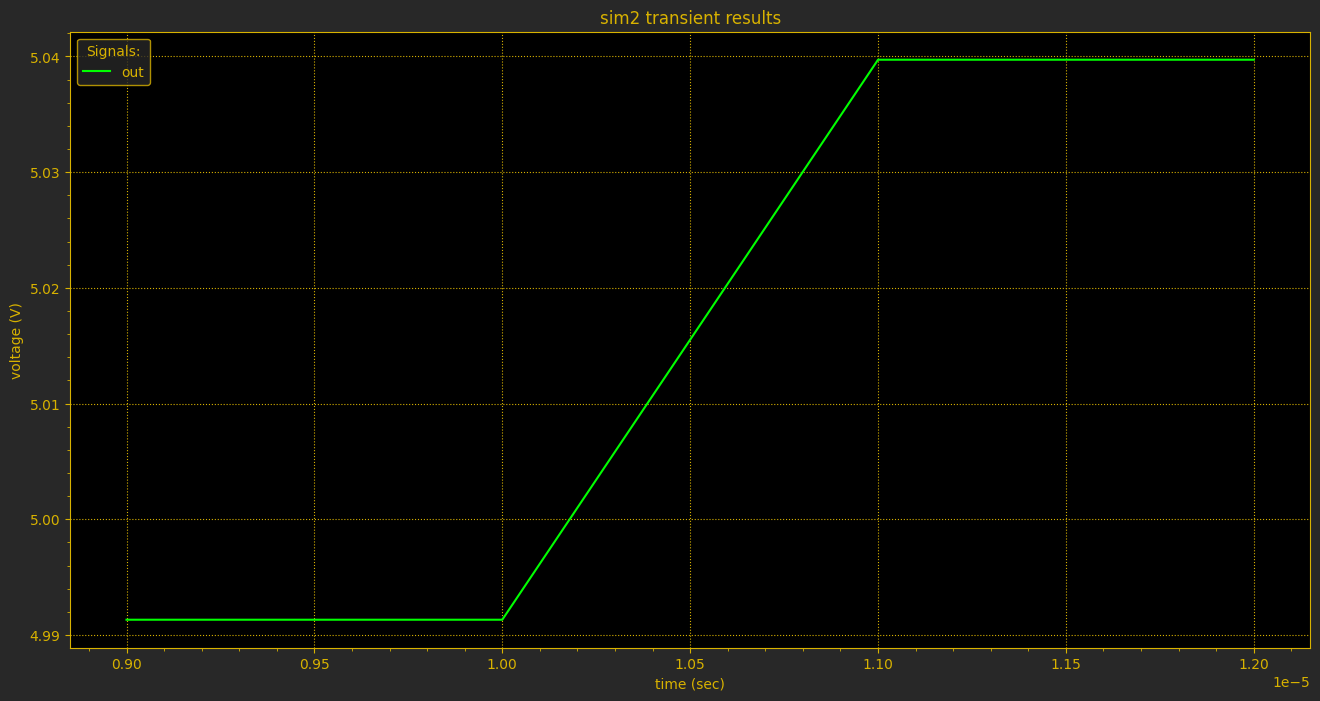


--- Part 2 calculations ---
Open loop gain (DC audio susceptibility): 9.98e-05
---------------------------



In [23]:
# Initialize
paths_dict, netlists_dict, vectors_dict = initialize(config_file_decoding)

# Simulate1: Operating Point and Transfer Function
sim_results1, netlists_dict = simulate1(paths_dict, netlists_dict, vectors_dict)

# Simulate2: Transient
sim_results2, netlists_dict = simulate2(paths_dict, netlists_dict, vectors_dict)

analyze_results(sim_results1, sim_results2, vectors_dict, paths_dict[Key.RESULTS_PATH])